### Quantifying cooperativity for a PH membrane-binding probe (negative control)

Context:
- Negative control for an assay for quantifying membrane-binding cooperativity
- Relies on measurements of membrane and cytoplasmic concentration in cells with varying quantities of total protein
- An effective exponent is quantified by performing linear regression on log-transformed data

Results:
- Here the exponent is close to 1, showing that the assay works as intended

Dependencies:
- Relies on quantification data from _Run/ph_quantify.ipynb_

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st

from src import (
    ExponentConfidenceInterval,
    bounded_mean_1d,
    fake_log,
    minor_ticks,
    nb_setup,
)

nb_setup()
os.makedirs("Figs", exist_ok=True)
os.makedirs("../../../data/EMBO_source_data", exist_ok=True)

%matplotlib inline

In [2]:
# Import data
df = pd.read_csv("../../../data/ph_embryos.csv")
df_quantification = pd.read_csv("../../../data/ph_quantification.csv")

# Filter relevant data
df = df[df.Line == "od58"]
df_quantification = df_quantification[df_quantification.EmbryoID.isin(df.EmbryoID)]


# Perform summary quantification
def calculate_summary(group):
    cyt = group["Cytoplasmic signal"].mean()
    mem_tot = group["Membrane signal"].mean()
    mem_ant = bounded_mean_1d(group["Membrane signal"], [0.4, 0.6])
    mem_post = bounded_mean_1d(group["Membrane signal"], [0.9, 0.1])
    return pd.Series(
        {
            "Cyt": cyt,
            "Mem_tot": mem_tot,
            "Mem_ant": mem_ant,
            "Mem_post": mem_post,
        }
    )


df_summary = (
    df_quantification.groupby("EmbryoID").apply(calculate_summary).reset_index()
)
df = pd.merge(df, df_summary, on="EmbryoID")

# Add uniform vs polarised column
df["UniPol"] = "Uni"

### Plotting functions

In [3]:
def plot_rundown_ci(ax, res, color):
    ax.plot(
        res.res_x,
        res.res_y,
        c="k",
        zorder=100,
        linewidth=1,
        label=r"$y = \beta x^\alpha$",
    )
    ax.fill_between(
        res.res_x,
        res.all_fits_lower,
        res.all_fits_upper,
        alpha=0.1,
        color="k",
        zorder=100,
    )
    ax.set_xlabel("Cytoplasmic conc. (a.u.)", fontsize=9)
    ax.set_ylabel("Membrane conc. (a.u.)", fontsize=9)
    ax.tick_params(axis="both", labelsize=8)
    ax.scatter(res.cyts, res.mems, color=color, linewidth=0.1, edgecolors="k", s=20)

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    for i in np.arange(-10, 10, 0.5):
        ax.plot([-10, 10], [i - 10, i + 10], c="0.9", zorder=-100, linewidth=1)
    ax.set_xticks(np.arange(0, 10))
    ax.set_yticks(np.arange(0, 10))
    minor_ticks(ax, [0, 10], [0, 10])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.xaxis.set_major_formatter(fake_log)
    ax.yaxis.set_major_formatter(fake_log)
    ax.set_aspect("equal", adjustable="datalim")
    ax.legend(frameon=False, fontsize=8, loc="lower right")


def violin(ax, res, xpos, color):
    kde = st.gaussian_kde(res.exponents)
    xx = np.linspace(min(res.exponents), max(res.exponents), 10000)
    kde_xx = kde(xx)
    ax.fill_betweenx(
        xx,
        xpos - 0.8 * (kde_xx / max(kde_xx)),
        xpos + 0.8 * (kde_xx / max(kde_xx)),
        color=color,
        linewidth=0,
    )
    ax.plot(
        [xpos, xpos],
        [np.percentile(res.exponents, 2.5), np.percentile(res.exponents, 97.5)],
        c="k",
        linewidth=0.5,
    )
    ax.scatter(xpos, res.exponent_full, c="k", s=5)

### Plot: PH rundown

In [4]:
analysis = ExponentConfidenceInterval(df, whole_embryo=True)

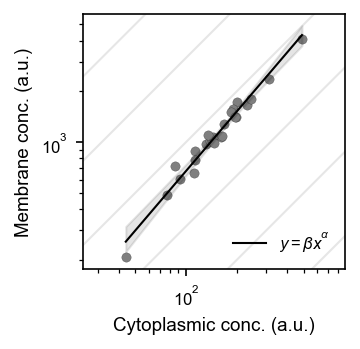

In [5]:
# Create figure
fig, ax = plt.subplots()
plot_rundown_ci(ax, analysis, "tab:gray")
fig.set_size_inches(2.5, 2.5)
fig.subplots_adjust(left=0.2, bottom=0.2)

# Save figure
fig.savefig("Figs/ph_rundown_log.png", dpi=600, transparent=True)
fig.savefig("Figs/ph_rundown_log.pdf", transparent=True)

# SourceData
df.to_csv("../../../data/EMBO_source_data/1F.csv", index=False)

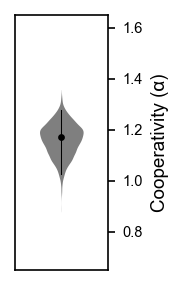

In [6]:
fig, ax = plt.subplots()
violin(ax, analysis, 1, "tab:gray")
ax.set_xlim(-0.7, 2.7)
ax.set_ylim(0.65, 1.65)
ax.set_xticks([])
ax.set_ylabel("Cooperativity (α)", fontsize=9)
ax.tick_params(axis="y", labelsize=7)
ax.tick_params(axis="x", labelsize=9)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

fig.set_size_inches(1.3, 2.5)
fig.subplots_adjust(bottom=0.2, right=0.6)
fig.savefig("Figs/ph_exponent.png", dpi=600, transparent=True)
fig.savefig("Figs/ph_exponent.pdf", transparent=True)